<a href="https://colab.research.google.com/github/krishnapatury/DataScience/blob/main/KrishnaPatury_Malaria_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Malaria Detection**

##<b>Problem Definition</b>
**Context:**<br>
Malaria is a contagious disease caused by infected female Anopheles mosquitoes by parasites entering the blood and damaging red blood cells (RBCs) that carry oxygen. Late treatment can be fatal, with almost 50% of the world’s population in danger of malaria. In 2019, children accounted for 67% of all malaria deaths worldwide. 

Diagnosis in the laboratory depends heavily on human expertise in distinguishing infected cells from healthy cells and is time-consuming, and accuracy is affected by variability in manual classification. Automated tools might provide quicker and better results to help with early detection. 

<br>**Objectives:** <br>
Building an efficient computer vision model to identify whether a given image of a red blood cell is infected with malaria or not, and classify the same as parasitized or uninfected, respectively.

<br>**Key questions:** <br>
Given a set of images of both parasitized and uninfected cells, learning the differences between the two to accurately classify unseen images.

<br>**Problem formulation:**<br>
Achieve faster results and better accuracy in malaria classification by reducing variability due to manual intervention. 

## <br><b>Data Description </b>
There are a total of 24,958 train and 2,600 test images (colored) taken from microscopic images. These images are of the following categories:<br>


**Parasitized:** The parasitized cells contain the Plasmodium parasite which causes malaria<br>
**Uninfected:** The uninfected cells are free of the Plasmodium parasites<br>


###<b> Mount the Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### <b>Load libraries</b>

In [2]:
# OpenCV to convert images from RGB to HSV
import cv2

# Kera libraries for building the deep learning models
from keras import backend
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

# For reading image files from directory
import os

# For numerical operations
import numpy as np

# For plotting graphs
import matplotlib.pyplot as plt

# For scientific operations and data manipulations
import pandas as pd

# For reading an image
from PIL import Image

# For randomizing data access
from random import shuffle
import random

# For visualizations
import seaborn as sns

# For splitting data for training and testing
from sklearn.model_selection import train_test_split
# For model evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# For displaying tabular data
from tabulate import tabulate
# For setting random seed to randomize in the same way for each execution
from tensorflow import random as tfr

# For accessing zipfile contents
import zipfile

### <b>Load the data</b>

In [3]:
# Extracts zip file
with zipfile.ZipFile('/content/drive/MyDrive/ADSP/DeepLearning/cell_images.zip', 'r') as zip_ref:
    zip_ref.extractall()

The extracted folder has different folders for train and test data containing images of different sizes for parasitized and uninfected cells within the respective folder name. 

The images need to be resized to be of same size, and converted to 4D arrays to be used as an input for the convolutional neural network. The train and test data also needs to be labeled (0-Uninfected and 1-Parasitized).

In [4]:
# Size of image so that each image has the same size
IMG_SIZE = 64
# Label for parasitized images
PARASITIZED = 1
# Label for uninfected images
UNINFECTED = 0

# Reads the images from the path parameter, resizes the images, converts them to Numpy arrays, and
# creates labels based on the folder from which they are read(0 - uninfected, 1 - parasitized)
def getConvertedImages(path):

  # Dictionary to hold images and labels for training/test data
  data = dict(images = [], labels = [])

  # Run the same code for "parasitized" as well as "uninfected" folders
  for folder_name in ['/parasitized/', '/uninfected/']:
    
    # Path of the folder
    images_path = os.listdir(path + folder_name)

    for i, image_name in enumerate(images_path): 
      try:
      
          # Open each image using the path of that image
          image = Image.open(path + folder_name + image_name)

          # Resize each image to (64, 64)
          image = image.resize((IMG_SIZE, IMG_SIZE))

          # Convert images to arrays and append to input list
          data["images"].append(np.array(image))

          # Create labels for parasitized and uninfected images
          if folder_name == '/parasitized/':
              data["labels"].append(PARASITIZED)
          else:
              data["labels"].append(UNINFECTED)
        
      except Exception:
          pass       

  # Converting lists to arrays
  data["images"] = np.array(data["images"])
  data["labels"] = np.array(data["labels"])

  return data

###<b> Read the training and images and label them

In [5]:
# Get the training data
train_data = getConvertedImages('/content/cell_images/train')

# Get the test data
test_data = getConvertedImages('/content/cell_images/test')

###<b> Check the shapes of the training and test data.

In [6]:
# Shape of training images and labels
print("Shape of training images is", train_data["images"].shape, "and training labels is", train_data["labels"].shape)

# Shape of test images and labels
print("Shape of test images is", test_data["images"].shape, "and test labels is", test_data["labels"].shape)

Shape of training images is (24958, 64, 64, 3) and training labels is (24958,)
Shape of test images is (2600, 64, 64, 3) and test labels is (2600,)


####<b> Observations and insights:</b>

There are 24958 images in the training data with each image of dimensions 64X64X3. The 3 channels indicate the images are color images. There are 2600 similar images in the testing data.


### <b>Check the range of pixel values for train and test images

In [7]:
print("The training images range from a min of", train_data["images"].min(), "to a max of", train_data["images"].max(), "pixels each.")
print("The test images range from a min of", test_data["images"].min(), "to a max of", test_data["images"].max(), "pixels each.")

The training images range from a min of 0 to a max of 255 pixels each.
The test images range from a min of 0 to a max of 255 pixels each.


####<b> Observations and insights: </b>

Each image has 3 channels each represented between 0 anbd 255 pixels.



###<b> Count the number of values in both uninfected and parasitized 

In [8]:
#Converted to Pandas DataFrames to access value_counts()
train_labels = pd.DataFrame(data=train_data['labels'], columns=['is_infected'])
print("Counts for training data: \n", train_labels['is_infected'].value_counts(), "\n")

test_labels = pd.DataFrame(data=test_data['labels'], columns=['is_infected'])
print("Counts for test data: \n", test_labels['is_infected'].value_counts())

Counts for training data: 
 1    12582
0    12376
Name: is_infected, dtype: int64 

Counts for test data: 
 1    1300
0    1300
Name: is_infected, dtype: int64


###<b>Normalize the images

In [9]:
# As the image pixel values range from 0 - 255, we can simply divide all the 
# pixel values by 255 to standardize all the images to have values between 0 - 1.
train_data["images"] = train_data["images"].astype('float32')/255.0
test_data["images"] = test_data["images"].astype('float32')/255.0

####<b> Observations and insights: </b>

There are 1,300 images with and without infections in the test data. The training data has slightly more parasitized images (12,582) compared to images without infections(12,376). Overall, the data can be considered balanced.

###<b> Plots to display balance of the data between parasitized and uninfected.

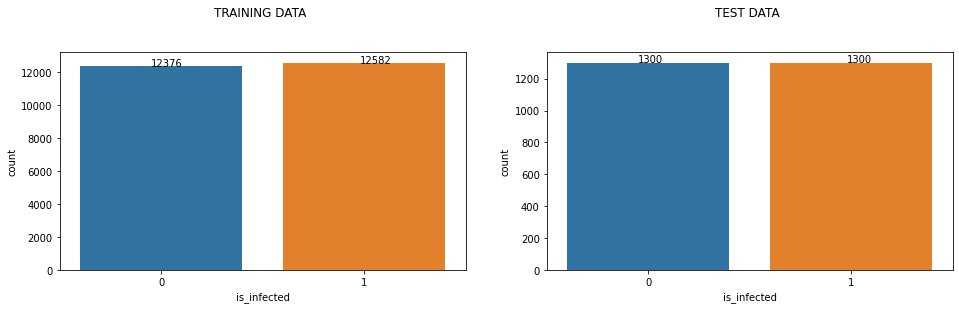

In [10]:
# Count plot to visualize balance of data
plt.figure(figsize = (16, 4))

plt.subplot(1, 2, 1)
plt.title("TRAINING DATA \n\n")
# Labels on the bars with counts
plt.text(x=-0.05, y=train_labels['is_infected'].value_counts()[0]+2, s=train_labels['is_infected'].value_counts()[0])
plt.text(x=0.98, y=train_labels['is_infected'].value_counts()[1]+2, s=train_labels['is_infected'].value_counts()[1])
sns.countplot(x = 'is_infected', data = train_labels)

plt.subplot(1, 2, 2)
plt.title("TEST DATA \n\n")
plt.text(x=-0.05, y=test_labels['is_infected'].value_counts()[0]+2, s=test_labels['is_infected'].value_counts()[0])
plt.text(x=0.98, y=test_labels['is_infected'].value_counts()[1]+2, s=test_labels['is_infected'].value_counts()[1])
sns.countplot(x = 'is_infected', data = test_labels)

plt.show()

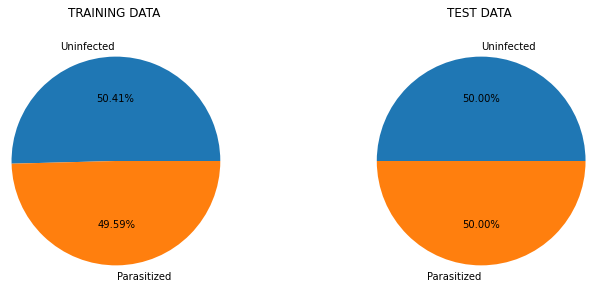

In [11]:
# Pie plots too show distribution as a percentage
plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.title("TRAINING DATA \n\n")
# 'autopct' displays the percentage upto 2 decimal place
plt.pie(train_labels.value_counts(), autopct = '%.2f%%', radius = 1.2, labels = ['Uninfected', 'Parasitized'])

plt.subplot(1, 2, 2)
plt.title("TEST DATA \n\n")
plt.pie(test_labels.value_counts(), autopct = '%.2f%%', radius = 1.2, labels = ['Uninfected', 'Parasitized'])

plt.show()

####<b> Observations and insights: </b>

The data is pretty balanced across both datasets. So we can use the appropriate evaluation methods for balanced classification like Precision and Recall to evaluate the models.

### <b>Data Exploration</b>
Visualizing the parasitized and uninfected images in the train and test data to understand the similarities and differences better.

In [12]:
# Visualizing the parasitized and uninfected images in the train and test data
def visualiseData(data):
  
  # To get the same images each time the code is run
  np.random.seed(42)

  plt.figure(1, figsize = (12 , 12))
  for n in range(1, 37):
      plt.subplot(6, 6, n)
      index = int(np.random.randint(0, data["images"].shape[0], 1))
      plt.title((lambda imgtype : "Parasitized" if imgtype ==  PARASITIZED else "Uninfected") (data["labels"][index]))
      plt.imshow(data["images"][index])
      plt.axis('off')

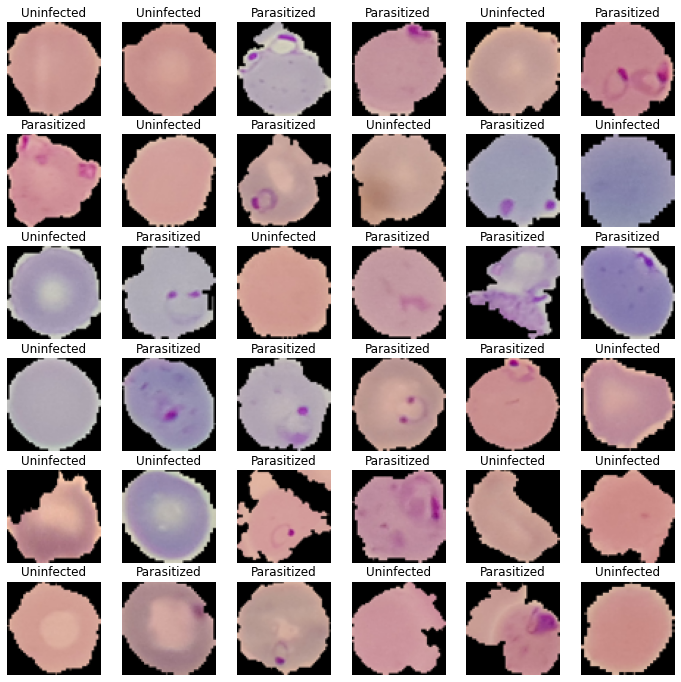

In [13]:
visualiseData(train_data)

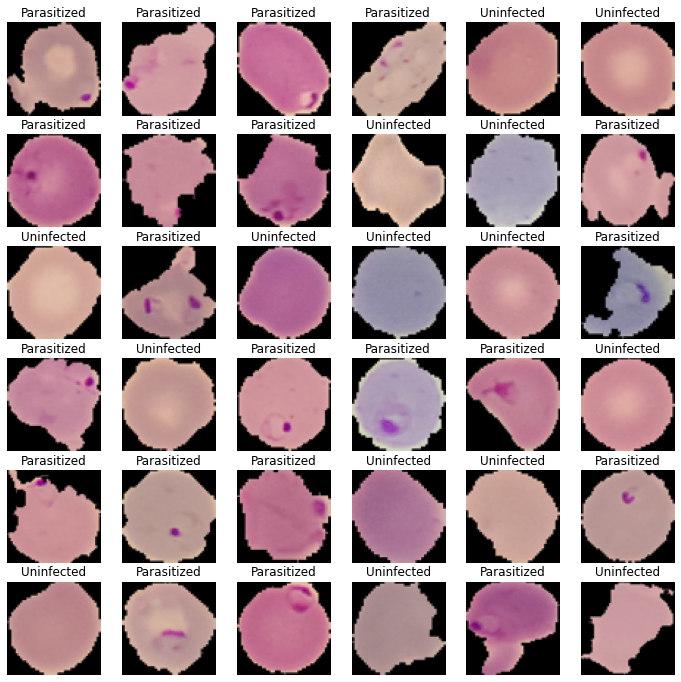

In [14]:
visualiseData(test_data)

####<b> Observations and insights: </b>

The infected images have a visible coloration in different areas of the image. The uninfected ones are more or less a single shade. Sometimes, both images seem to have a center in a different shade. The infected markings have to be fairly dark in intensity to be considered parasitized. They also seem to be mostly at the periphery of the cells altough this is not always true( ex: 27th image in the test data).

###<b> Plotting the mean images for parasitized and uninfected

In [15]:
# Function to plot the mean image
def plotMeanImg(data, imgtype):

  imgLabel = (lambda x : "Parasitized" if x ==  PARASITIZED else "Uninfected") (imgtype)

  relevant_data = []
  for index, label in np.ndenumerate(data["labels"]):
    if label == imgtype:
      relevant_data.append([data["images"][index]]) 

  print("\nNumber of ",  imgLabel, " images: ", len(relevant_data), "\n")
  images = np.array(relevant_data)
  
  # Calculate the average
  averageImg = np.mean(images, axis = 0)[0]

  # Reshape it back to a matrix
  plt.imshow(averageImg)
  plt.title("Average " + imgLabel)
  plt.axis('off')
  plt.show()

<b> Mean for parasitized and uninfected images


Number of  Parasitized  images:  12582 



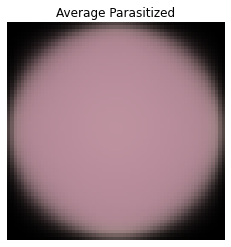


Number of  Uninfected  images:  12376 



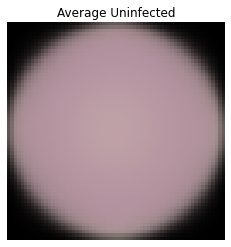

In [16]:
plotMeanImg(train_data, PARASITIZED)
plotMeanImg(train_data, UNINFECTED)

####<b> Observations and insights:</b>

The uninfected images on average seem to be paler than the infected ones in intensity. This makes sense as they parasitized ones have high intensity colorations representing the infections. 

### <b>Converting RGB to HSV of Images using OpenCV

In [17]:
def plotHSVImages(data):

  # Convert RGB images to HSV(Hue Saturation Value) images
  hsvImages=[]   
  for i in np.arange(0, 100, 1):
    hsvImages.append(cv2.cvtColor(data["images"][i], cv2.COLOR_BGR2HSV))

  hsvImages = np.array(hsvImages)

  # Plotting 5 random images from the dataset
  viewimage = np.random.randint(1, 100, 5)
  fig, ax = plt.subplots(1, 5, figsize = (18, 18))

  for t, i in zip(range(5), viewimage):
    ax[t].set_title((lambda label : "Parasitized" if label ==  PARASITIZED else "Uninfected") (data["labels"][i]))
    #ax[t].imshow(hsvImages[i])
    # Removed normalization to address matplotlib warning
    #"WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers)."
    ax[t].imshow((hsvImages[i]*255).astype(np.uint8))
    ax[t].set_axis_off()
    fig.tight_layout()

###<b> Plot the training data

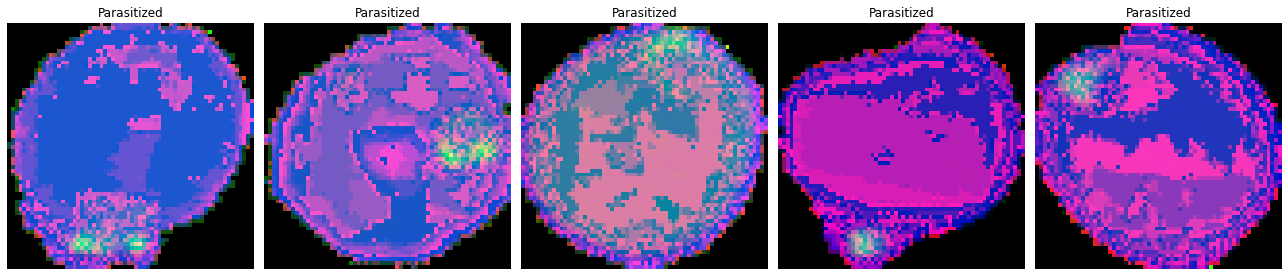

In [18]:
#Plot training data
plotHSVImages(train_data)

###<b> Plot the test data

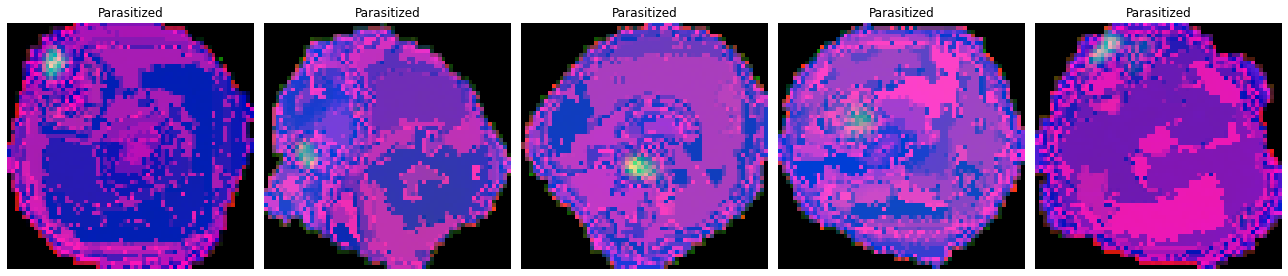

In [19]:
#Plot training data
plotHSVImages(test_data)

####<b>Observations and insights: 

It seems slightly more difficult to identify infections in the HSV model. It looks much better with the normalized data.

###<b> Processing Images using Gaussian Blurring

In [20]:
def applyGaussianBlurring(data):

  # To hold the blurred images
  gbx = []  
  for i in np.arange(0, 100, 1):
    gbx.append(cv2.GaussianBlur(data["images"][i], (5, 5), 0))
  gbx = np.array(gbx)

  viewimage = np.random.randint(1, 100, 5)
  fig, ax = plt.subplots(1, 5, figsize = (18, 18))
  for t, i in zip(range(5), viewimage):
    ax[t].set_title((lambda label : "Parasitized" if label ==  PARASITIZED else "Uninfected") (data["labels"][i]))
    ax[t].imshow(gbx[i])
    ax[t].set_axis_off()
    fig.tight_layout()

###<b> Gaussian Blurring on train data

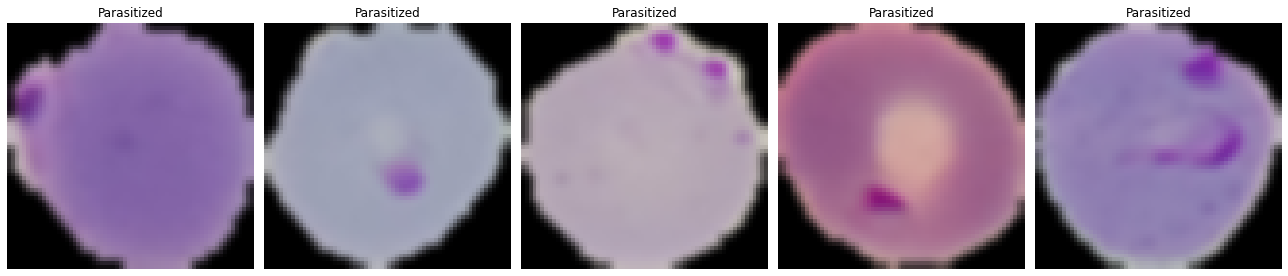

In [21]:
#Gaussian Blurring on train data
applyGaussianBlurring(train_data)

###<b> Gaussian Blurring on test data

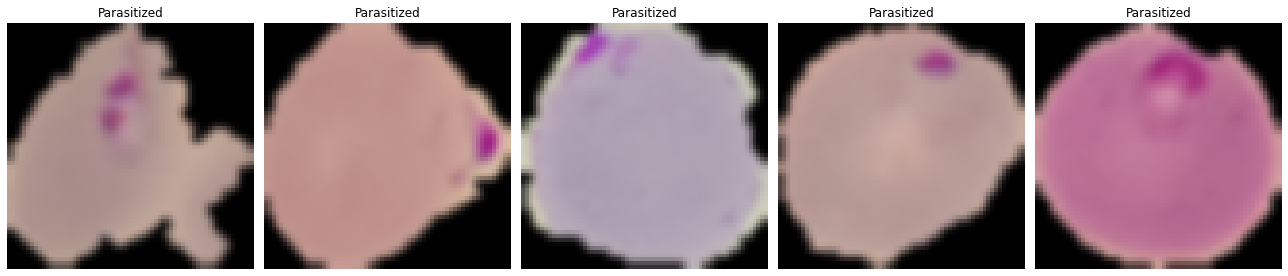

In [22]:
# Gaussian Blurring on test data
applyGaussianBlurring(test_data)

####Observations and insights: 

Blurring seems to help the human eye but I wonder if this would cause some of the parasitized images to be considered as uninfected. 

## **Model Building**

###<b> Custom methods for building and evaluating the Models

In [23]:
# Method to clear out previous model's history and fix random seeds to get same results for each run
def softreset():
  # Clearing backend
  backend.clear_session()

  # By setting the seed for random number generators in Numpy, the Random library in Python, 
  # and in TensorFlow, we can reproduce same results every time we run the code.
  np.random.seed(42)
  random.seed(42)
  tfr.set_seed(42)


# Method to generate a classification report and plot the heatmap using confusion matrix
def printMetrics(actual, predicted):

  # Each entry of the target variable is a one-hot encoded vector. 
  # To print the classification report and confusion matrix, convert each entry to a single label.
  predicted_value = np.argmax(predicted, axis = 1)
  actual_value = np.argmax(actual, axis = 1)

  # Printing the classification report
  print(classification_report(actual_value, predicted_value))

  # Plotting the heatmap using confusion matrix
  cm = confusion_matrix(actual_value, predicted_value)     
  plt.figure(figsize = (8, 5))
  sns.heatmap(cm, annot = True,  fmt = '.0f', 
              xticklabels = ['Uninfected', 'Parasitized'], 
              yticklabels = ['Uninfected', 'Parasitized'])
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()


# Method for plotting the validation and training accuracies
def accuracyPlot(model_hist):

  dict_hist = model_hist.history
  nepochs = len(dict_hist['accuracy'])
  list_ep = [i for i in range(1, nepochs+1)]

  plt.figure(figsize = (8, 8))
  plt.title("Accuracy vs Epoch Plot")
  plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')
  plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.legend(loc="upper right")
  plt.show()


# Method to print model accuracy on test data for all the models built
def modelsAccuracies():

  table = [['Model Details', 'Accuracy'], 
           ['Base Model', accuracy[1] ],
           ['Model 1 (with some Dropouts and relu)', accuracy1[1]],
           ['Model 2 (with Batch Normalization and LeakyRelu)', accuracy2[1]],
           ['Model 3 (with Data Augmentation)', accuracy3[1]],
           ['Model 4 (with transfer learning)', accuracy4[1]]]
  
  print(tabulate(table, headers='firstrow'))

## **Base Model**

In [24]:
# Clear Keras backend
softreset()

###<B>One Hot Encoding the train and test labels</b>

There are two classes into each image will be classified, parasitized(1) and uninfected(0). 

In [25]:
# Encoding Training Labels
train_data["labels"] = to_categorical(train_data["labels"], num_classes=2)

# Encoding Test Labels
test_data["labels"] = to_categorical(test_data["labels"], num_classes=2)

###<b> Building the base model

In [26]:
# Creating sequential model
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu", input_shape = (64, 64, 3)))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.4))

# Output layer, using softmax activator for 2 class classification
model.add(Dense(2, activation = "softmax")) 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

###<b> Compiling the model

In [27]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

<b> Using Callbacks 

In [28]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b> Fit and train the Model

In [29]:
# Fit the model with min batch size as 32 so can tune batch size to a factor of 2^power ] 
history = model.fit(train_data["images"], train_data["labels"], batch_size = 32, callbacks = callbacks, 
                    validation_split = 0.2, epochs = 10, verbose = 1)

Epoch 1/10
624/624 [==============================] - 18s 9ms/step - loss: 0.3778 - accuracy: 0.8258 - val_loss: 0.2481 - val_accuracy: 0.9137
Epoch 2/10
624/624 [==============================] - 5s 8ms/step - loss: 0.1125 - accuracy: 0.9599 - val_loss: 0.0962 - val_accuracy: 0.9896
Epoch 3/10
624/624 [==============================] - 4s 7ms/step - loss: 0.0808 - accuracy: 0.9744 - val_loss: 0.0521 - val_accuracy: 0.9912
Epoch 4/10
624/624 [==============================] - 5s 8ms/step - loss: 0.0751 - accuracy: 0.9751 - val_loss: 0.0613 - val_accuracy: 0.9872
Epoch 5/10
624/624 [==============================] - 5s 8ms/step - loss: 0.0718 - accuracy: 0.9768 - val_loss: 0.0656 - val_accuracy: 0.9848


###<b> Evaluating the model on test data

In [30]:
accuracy = model.evaluate(test_data["images"], test_data["labels"], verbose = 1)
print('\n', 'Accuracy on test data: ', accuracy[1])

82/82 [==============================] - 0s 4ms/step - loss: 0.0596 - accuracy: 0.9819

 Accuracy on test data:  0.9819231033325195


<b> Plotting the confusion matrix

82/82 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1300
           1       0.98      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



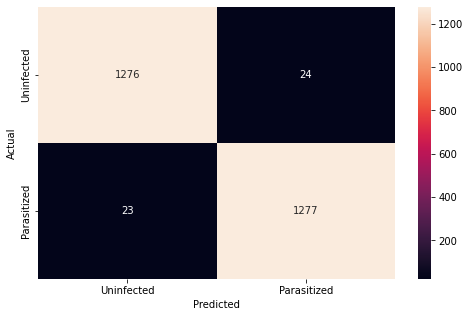

In [31]:
predicted = model.predict(test_data["images"])
printMetrics(test_data["labels"], predicted)

<b>Plotting the train and validation curves

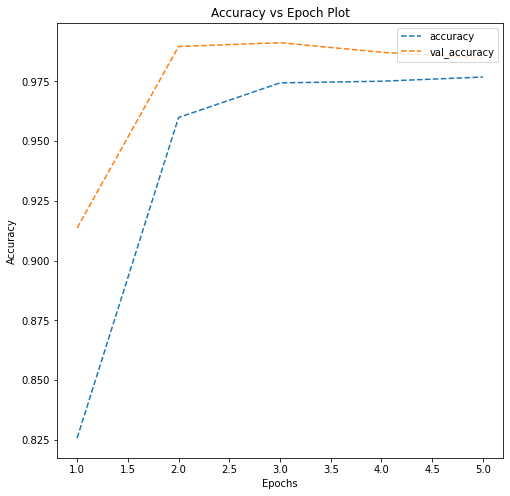

In [32]:
accuracyPlot(history)

Both validation and testing accuracy increased well before plateauing at .98. The model seemed to have generalized well.

##<b> Model 1 with more convolution layers and dropouts</b>
Building another model by adding more convolution filters, layers and increasing dropouts to try to improve the performance.

In [33]:
# Clear Keras backend
softreset()

###<b> Building the Model

In [34]:
def model1():
  # Creating sequential model
  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu", input_shape = (64, 64, 3)))
  model.add(MaxPooling2D(pool_size = 2))
  model.add(Dropout(0.3))

  model.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))
  model.add(MaxPooling2D(pool_size = 2))
  model.add(Dropout(0.3))

  model.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))
  model.add(MaxPooling2D(pool_size = 2))
  model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(512, activation = "relu"))
  model.add(Dropout(0.5))

  # Output layer
  model.add(Dense(2, activation = "softmax")) 
  
  return model

model1 = model1()
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

###<b> Compiling the model

In [35]:
model1.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])

<b> Using Callbacks

In [36]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b>Fit and Train the model

In [37]:
# Increasing the batch size to 64, leaving epochs as 10 as it stopped sooner before.
model1_history = model1.fit(train_data["images"], train_data["labels"], batch_size = 64, callbacks = callbacks, 
                    validation_split = 0.2, epochs = 10, verbose = 1)

Epoch 1/10
312/312 [==============================] - 5s 15ms/step - loss: 0.5450 - accuracy: 0.7257 - val_loss: 0.3726 - val_accuracy: 0.9443
Epoch 2/10
312/312 [==============================] - 3s 11ms/step - loss: 0.1736 - accuracy: 0.9373 - val_loss: 0.1414 - val_accuracy: 0.9561
Epoch 3/10
312/312 [==============================] - 3s 10ms/step - loss: 0.1302 - accuracy: 0.9501 - val_loss: 0.1337 - val_accuracy: 0.9730
Epoch 4/10
312/312 [==============================] - 3s 10ms/step - loss: 0.1169 - accuracy: 0.9589 - val_loss: 0.1181 - val_accuracy: 0.9856
Epoch 5/10
312/312 [==============================] - 4s 12ms/step - loss: 0.1063 - accuracy: 0.9655 - val_loss: 0.0852 - val_accuracy: 0.9864
Epoch 6/10
312/312 [==============================] - 3s 11ms/step - loss: 0.0987 - accuracy: 0.9688 - val_loss: 0.1103 - val_accuracy: 0.9834
Epoch 7/10
312/312 [==============================] - 3s 10ms/step - loss: 0.0944 - accuracy: 0.9691 - val_loss: 0.0590 - val_accuracy: 0.9912

###<b> Evaluating the model

In [38]:
accuracy1 = model1.evaluate(test_data["images"], test_data["labels"],  verbose = 1)
print('\n', 'Accuracy on test data: ', accuracy1[1])

82/82 [==============================] - 1s 5ms/step - loss: 0.0762 - accuracy: 0.9827

 Accuracy on test data:  0.982692301273346


<b> Plotting the confusion matrix

82/82 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1300
           1       0.98      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



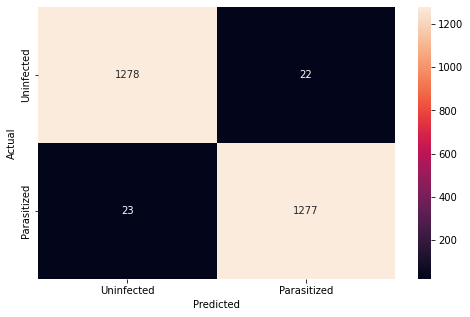

In [39]:
predicted_model1 = model1.predict(test_data["images"])
printMetrics(test_data["labels"], predicted_model1)

<b> Plotting the train and the validation curves

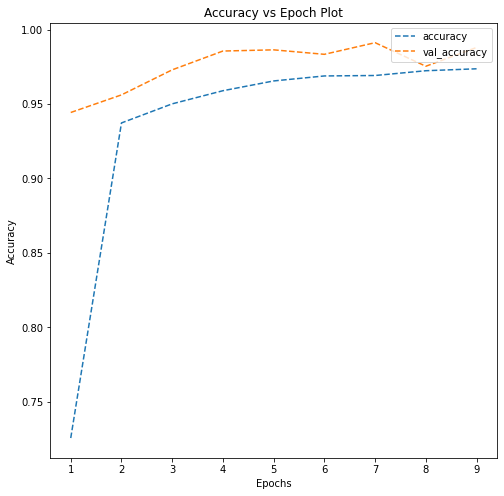

In [40]:
accuracyPlot(model1_history)

##<b> Model 2 with Batch Normalization </b>

There was a slight improvement from the base model, built another model using BatchNormalization and using LeakyRelu as the activation function.

In [41]:
# Clear Keras backend
softreset()

###<b> Building the Model

In [42]:
def model2():
  # Creating sequential model
  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", input_shape = (64, 64, 3)))
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(pool_size = 2))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  model.add(Conv2D(filters = 64, kernel_size = 2, padding = "same"))
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(pool_size = 2))
  model.add(BatchNormalization())

  model.add(Conv2D(filters = 32, kernel_size = 2, padding = "same"))
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(pool_size = 2))
  model.add(BatchNormalization())

  model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(64))
  model.add(LeakyReLU(0.1))
  model.add(Dropout(0.5))

  # Output layer
  model.add(Dense(2, activation = "softmax")) 
  
  return model

model2 = model2()
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        8

###<b>Compiling the model

In [43]:
model2.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])

<b> Using callbacks

In [44]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b>Fit and train the model

In [45]:
# Kept the batch size of 64, leaving epochs as 10 as it stopped sooner before.
model2_history = model2.fit(train_data["images"], train_data["labels"], batch_size = 64, callbacks = callbacks, 
                    validation_split = 0.2, epochs = 10, verbose = 1)

Epoch 1/10
312/312 [==============================] - 6s 18ms/step - loss: 0.6062 - accuracy: 0.6956 - val_loss: 5.4048e-05 - val_accuracy: 1.0000
Epoch 2/10
312/312 [==============================] - 5s 16ms/step - loss: 0.2460 - accuracy: 0.9002 - val_loss: 0.0077 - val_accuracy: 0.9986
Epoch 3/10
312/312 [==============================] - 5s 15ms/step - loss: 0.1498 - accuracy: 0.9457 - val_loss: 0.0168 - val_accuracy: 0.9980


<b>Plotting the train and validation accuracy

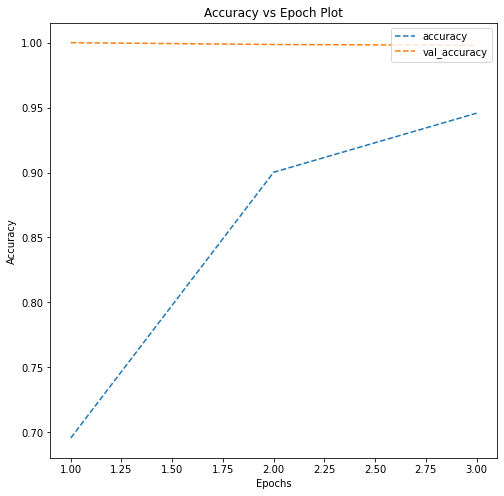

In [46]:
accuracyPlot(model2_history)

###<b>Evaluating the model

In [47]:
accuracy2 = model2.evaluate(test_data["images"], test_data["labels"],  verbose = 1)
print('Model 2 Accuracy on test data: ', accuracy2[1])

82/82 [==============================] - 1s 5ms/step - loss: 0.2559 - accuracy: 0.9354
Model 2 Accuracy on test data:  0.9353846311569214


####<b>Observations and insights: </b>
The accuracy on the validation data started at 1.00 and kept falling till the model was early stopped. The training accuracy steadily increased. 

<b> Generate the classification report and confusion matrix 

82/82 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1300
           1       1.00      0.87      0.93      1300

    accuracy                           0.94      2600
   macro avg       0.94      0.94      0.94      2600
weighted avg       0.94      0.94      0.94      2600



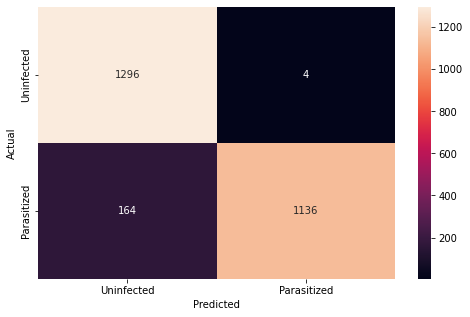

In [48]:
predicted_model2 = model2.predict(test_data["images"])
printMetrics(test_data["labels"], predicted_model2)

##<b>Model 3 with Data Augmentation </b>

Will apply data augmentation to see if it helps improve the model (applied only against training and validation data, not against test data).

In [49]:
# Clear Keras backend
softreset()

###<b> Use image data generator

In [50]:
X_train, X_val, y_train, y_val = train_test_split(train_data["images"], 
                                                  train_data["labels"], 
                                                  test_size = 0.2, 
                                                  random_state = 42)

# Using ImageDataGenerator to generate images
train_datagen = ImageDataGenerator(horizontal_flip = True, 
                                   zoom_range = 0.1, 
                                   shear_range = 0.1,
                                   rotation_range = 20,
                                   height_shift_range= 0.1, 
                                   width_shift_range=0.1)

# Flowing training images using train_datagen generator
train_generator = train_datagen.flow(x = train_data["images"], 
                                     y = train_data["labels"], 
                                     batch_size = 64, 
                                     seed = 42, shuffle = True)


# Flowing validation images using val_datagen generator
val_generator =  ImageDataGenerator().flow(x = train_data["images"], 
                                           y = train_data["labels"],
                                           batch_size = 64, 
                                           seed = 42, shuffle = True)

####<B>Visualizing Augmented images

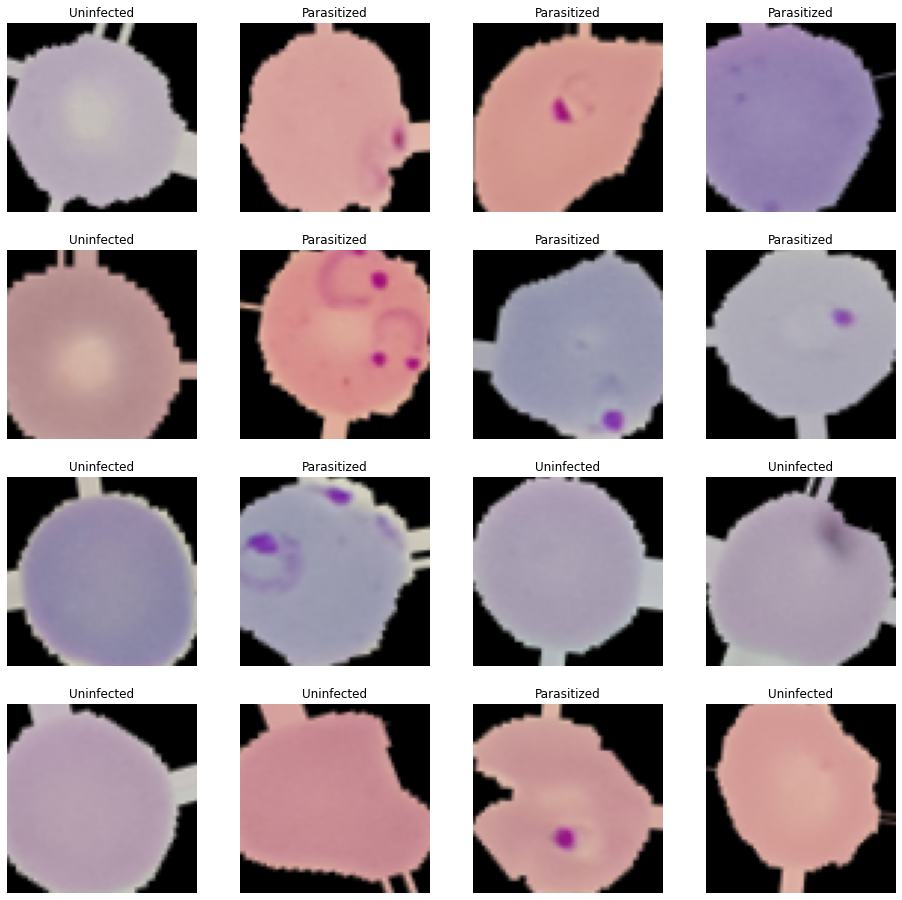

In [51]:
def visualizeAugmentedImgs(train_generator):

  images, labels = next(train_generator)
  fig, axes = plt.subplots(4, 4, figsize = (16, 8))
  fig.set_size_inches(16, 16)

  for (image, label, ax) in zip(images, labels, axes.flatten()):
    ax.imshow(image)
    ax.set_title((lambda x : "Parasitized" if x ==  PARASITIZED else "Uninfected") (label[1]))
    ax.axis('off')
    
visualizeAugmentedImgs(train_generator)

####<b>Observations and insights:</b>

It may not make much difference for the uninfected images but augmentation might help with infected images in translating the infection areas to different angles around the periphery.

###<b>Building the Model

In [52]:
model3 = Sequential()

model3.add(Conv2D(32, (3,3), input_shape=(64, 64, 3), padding = 'same'))
model3.add(LeakyReLU(0.1))
model3.add(MaxPooling2D(2,2))
model3.add(BatchNormalization())

model3.add(Conv2D(32, (3,3), padding = 'same'))
model3.add(LeakyReLU(0.1))
model3.add(MaxPooling2D(2,2))
model3.add(BatchNormalization())

model3.add(Conv2D(32, (3,3), padding = 'same'))
model3.add(LeakyReLU(0.1))
model3.add(MaxPooling2D(2,2))
model3.add(Conv2D(16, (3,3), padding = 'same'))
model3.add(LeakyReLU(0.1))

model3.add(Flatten())

model3.add(Dense(512))
model3.add(LeakyReLU(0.1))
model3.add(Dropout(0.25))

model3.add(Dense(64))
model3.add(LeakyReLU(0.1))
model3.add(Dropout(0.25))

model3.add(Dense(32))
model3.add(LeakyReLU(0.1))
model3.add(Dense(2, activation='softmax'))

model3.compile(loss = "categorical_crossentropy", optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])

model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0

<b>Using Callbacks

In [53]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b> Fit and Train the model

In [54]:
model3_history = model3.fit(train_data["images"], train_data["labels"], batch_size = 64, callbacks = callbacks, 
                    validation_split = 0.2, epochs = 10, verbose = 1)

Epoch 1/10
312/312 [==============================] - 6s 14ms/step - loss: 0.1966 - accuracy: 0.9176 - val_loss: 0.0720 - val_accuracy: 1.0000
Epoch 2/10
312/312 [==============================] - 4s 11ms/step - loss: 0.0698 - accuracy: 0.9771 - val_loss: 0.0991 - val_accuracy: 0.9964
Epoch 3/10
312/312 [==============================] - 4s 12ms/step - loss: 0.0630 - accuracy: 0.9799 - val_loss: 0.0440 - val_accuracy: 0.9892
Epoch 4/10
312/312 [==============================] - 4s 11ms/step - loss: 0.0562 - accuracy: 0.9810 - val_loss: 0.0318 - val_accuracy: 0.9896
Epoch 5/10
312/312 [==============================] - 3s 10ms/step - loss: 0.0552 - accuracy: 0.9815 - val_loss: 0.0408 - val_accuracy: 0.9884
Epoch 6/10
312/312 [==============================] - 3s 11ms/step - loss: 0.0490 - accuracy: 0.9820 - val_loss: 0.0827 - val_accuracy: 0.9796


###<B>Evaluating the model

In [55]:
accuracy3 = model3.evaluate(test_data["images"], test_data["labels"],  verbose = 1)
print('Model 3 Accuracy on test data: ', accuracy3[1])

82/82 [==============================] - 1s 6ms/step - loss: 0.0587 - accuracy: 0.9827
Model 3 Accuracy on test data:  0.982692301273346


<b>Plot the train and validation accuracy

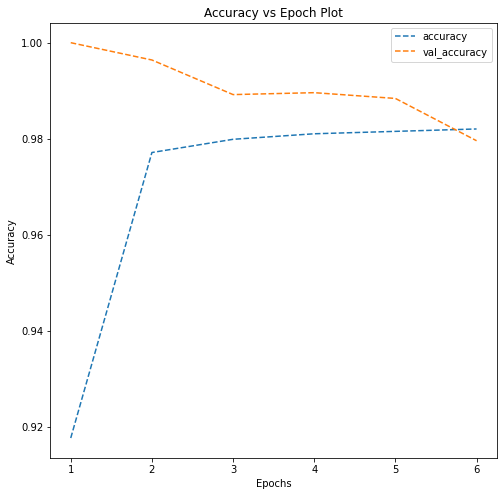

In [56]:
accuracyPlot(model3_history)

<B>Plotting the classification report and confusion matrix

82/82 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1300
           1       0.98      0.99      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



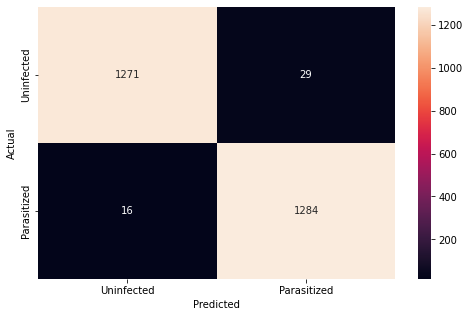

In [57]:
predicted_model3 = model3.predict(test_data["images"])
printMetrics(test_data["labels"], predicted_model3)

This model seems to have the highest accuracy and with the lowest misclassifications for parasitized images. 

## **Model 4 Pre-trained model (VGG16)**


In [58]:
# Clear Keras backend
softreset()

In [59]:
# Summary of the whole model
model = VGG16(weights='imagenet')
model.summary()

553467096/553467096 [==============================] - 24s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

###<b>Compiling the model

In [60]:
# Getting only the conv layers for transfer learning.
transfer_layer = model.get_layer('block5_pool')
#transfer_layer = model.get_layer('block3_pool')

vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (64,64,3))
vgg_model.summary()

# Making all the layers of the VGG model non-trainable. i.e. freezing them
vgg_model.trainable = False

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [61]:
model4 = Sequential()

# Adding the convolutional part of the VGG16 model from above
model4.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model4.add(Flatten())

# Adding a dense output layer
model4.add(Dense(64, activation='relu'))
model4.add(Dropout(0.3))

#model4.add(Dense(64, activation='relu'))
model4.add(BatchNormalization())

model4.add(Dense(2, activation='softmax'))

model4.compile(loss = "categorical_crossentropy", optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                        

<b> using callbacks

In [62]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b>Fit and Train the model

In [63]:
model4_history = model4.fit(train_data["images"], train_data["labels"], batch_size = 64, callbacks = callbacks, 
                    validation_split = 0.2, epochs = 10, verbose = 1)

Epoch 1/10
312/312 [==============================] - 14s 38ms/step - loss: 0.2463 - accuracy: 0.8971 - val_loss: 0.1819 - val_accuracy: 0.9573
Epoch 2/10
312/312 [==============================] - 9s 30ms/step - loss: 0.1766 - accuracy: 0.9306 - val_loss: 0.4207 - val_accuracy: 0.8496
Epoch 3/10
312/312 [==============================] - 10s 33ms/step - loss: 0.1701 - accuracy: 0.9348 - val_loss: 0.1880 - val_accuracy: 0.9437


<b>Plot the train and validation accuracy

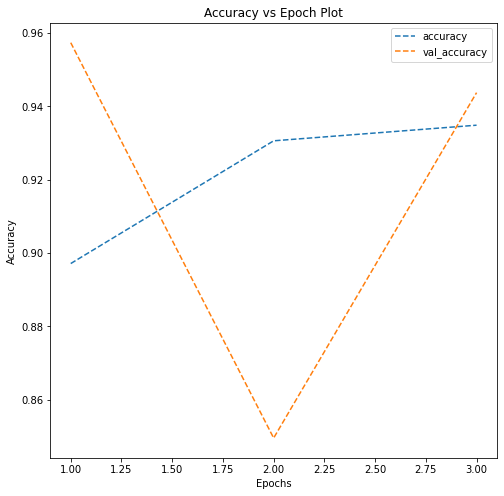

In [64]:
accuracyPlot(model4_history)

###Observations and insights:

*   Although the accuracy increased for the training data, the validation accuracy is very erratic. This behavior does not change much with fewer layers in the model with an attempt to reduce it's complexity. Overall, the performance on validation data is concerning despite a fairly decent accuracy.

###<b> Evaluating the model

In [65]:
accuracy4 = model4.evaluate(test_data["images"], test_data["labels"],  verbose = 1)
print('Model 4 Accuracy on test data: ', accuracy4[1])

82/82 [==============================] - 2s 20ms/step - loss: 0.1858 - accuracy: 0.9296
Model 4 Accuracy on test data:  0.9296153783798218


<b>Plotting the classification report and confusion matrix

82/82 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      1300
           1       0.90      0.97      0.93      1300

    accuracy                           0.93      2600
   macro avg       0.93      0.93      0.93      2600
weighted avg       0.93      0.93      0.93      2600



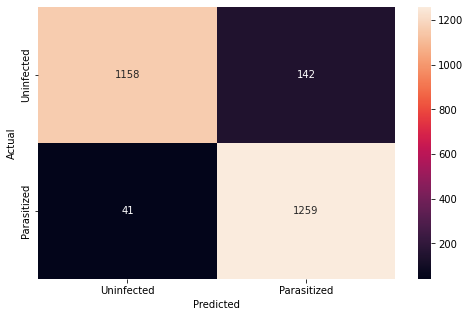

In [66]:
predicted_model4 = model4.predict(test_data["images"])
printMetrics(test_data["labels"], predicted_model4)

In [67]:
# Print the accuracies of the 5 models on the test data.
modelsAccuracies()

Model Details                                       Accuracy
------------------------------------------------  ----------
Base Model                                          0.981923
Model 1 (with some Dropouts and relu)               0.982692
Model 2 (with Batch Normalization and LeakyRelu)    0.935385
Model 3 (with Data Augmentation)                    0.982692
Model 4 (with transfer learning)                    0.929615


##<b> Observations and Conclusions drawn from the final model: </b>
The model using Data Augmentation seems to have performed the best and will be the final model based on accuracy and least number of misclassifications for the parasitized images. 

There might be other transfer learning models which perform better than the one chosen here. Trying several CNN architectures is pretty resource intensive and finding a transfer learning model that fits the problem data well seems worth the effort. 

It might be worth building the model using the HSV images as it is a different image representation that might suit this problem better. 


## **Insights**

####**Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?

####**Comparison of various techniques and their relative performance**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

####**Proposal for the final solution design**:
- What model do you propose to be adopted? Why is this the best solution to adopt?